In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from scipy import stats
from tqdm import tqdm


In [2]:
df = pd.read_csv('meteorite-landings.csv',index_col=[0])
df

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,geolocation
0,Aachen,1,Valid,L5,21.0,Fell,1880-01-01T00:00:00.000,50.77500,6.08333,"('50.775000', '6.083330')"
1,Aarhus,2,Valid,H6,720.0,Fell,1951-01-01T00:00:00.000,56.18333,10.23333,"('56.183330', '10.233330')"
2,Abee,6,Valid,EH4,107000.0,Fell,1952-01-01T00:00:00.000,54.21667,-113.00000,"('54.216670', '-113.000000')"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976-01-01T00:00:00.000,16.88333,-99.90000,"('16.883330', '-99.900000')"
4,Achiras,370,Valid,L6,780.0,Fell,1902-01-01T00:00:00.000,-33.16667,-64.95000,"('-33.166670', '-64.950000')"
...,...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990-01-01T00:00:00.000,29.03700,17.01850,"('29.037000', '17.018500')"
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999-01-01T00:00:00.000,13.78333,8.96667,"('13.783330', '8.966670')"
45713,Zlin,30410,Valid,H4,3.3,Found,1939-01-01T00:00:00.000,49.25000,17.66667,"('49.250000', '17.666670')"
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003-01-01T00:00:00.000,49.78917,41.50460,"('49.789170', '41.504600')"


# Features Analysis

As part of the feature analysis we are going to analyze each feature (column) to better understand our data.

### Name:

In [3]:
name = df["name"]

In [4]:
print("There are {} unique names out of {} total".format(len(name.unique()), len(name)))

There are 38115 unique names out of 38115 total


In [5]:
name

0            Aachen
1            Aarhus
2              Abee
3          Acapulco
4           Achiras
            ...    
45711    Zillah 002
45712        Zinder
45713          Zlin
45714     Zubkovsky
45715    Zulu Queen
Name: name, Length: 38115, dtype: object

In [6]:
 name.loc[name.str.startswith('Zillah', na=False)]

45710    Zillah 001
45711    Zillah 002
Name: name, dtype: object

As we can see some meteorites have the same name but with different number

In [7]:
def remove_non_alpha(string):
    return "".join(char for char in string if char.isalpha())

name = name.apply(remove_non_alpha)
name = name.str.lower()

In [8]:
print("There are {} unique names out of {} total".format(len(name.unique()), len(name)))

There are 3314 unique names out of 38115 total


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


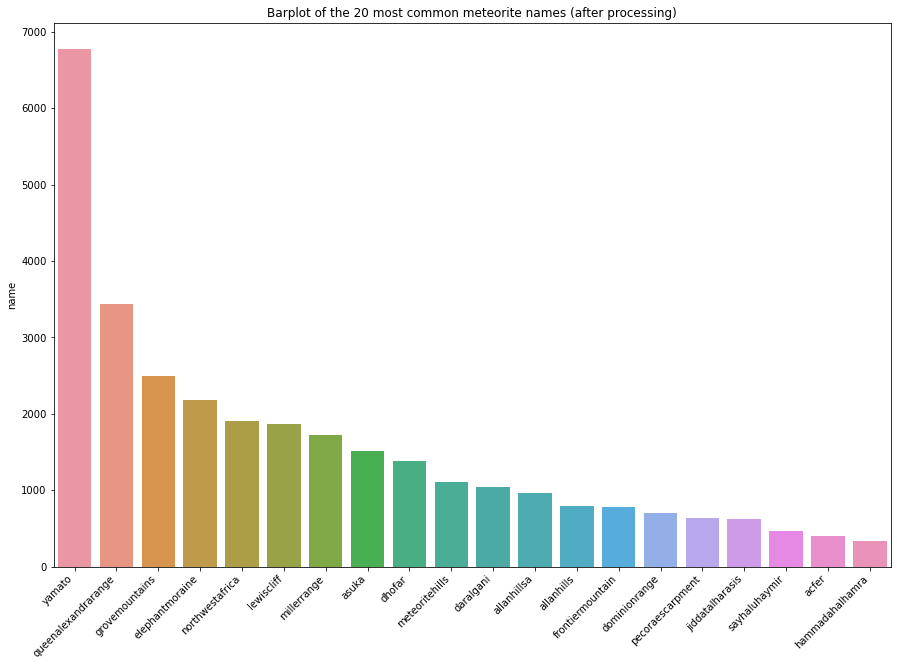

In [9]:
plt.rcParams['figure.figsize'] = [15, 10]

twenty_most_common_names = name.value_counts()[:20]
common_names_barplot = sns.barplot(twenty_most_common_names.keys(), twenty_most_common_names);
common_names_barplot.set_xticklabels(common_names_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
common_names_barplot.set_title("Barplot of the 20 most common meteorite names (after processing)")
common_names_barplot;

As we can see "yamato" and "queenalexandarange" are the most common meteorite names.
After some research we discovered that those names are names of glacier and a mountain range in Antarctica.

### GeoLocation (Reclat, Reclong)

In [13]:
# geolocation value of (0.0,0.0) is meaningless
ds_geo = df[(df["reclat"] != 0.0) & (df["reclong"] != 0.0)]["geolocation"]

In [14]:
print("There are {} unique locations out of {} total".format(len(ds_geo.unique()), len(ds_geo)))

There are 16904 unique locations out of 31705 total


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


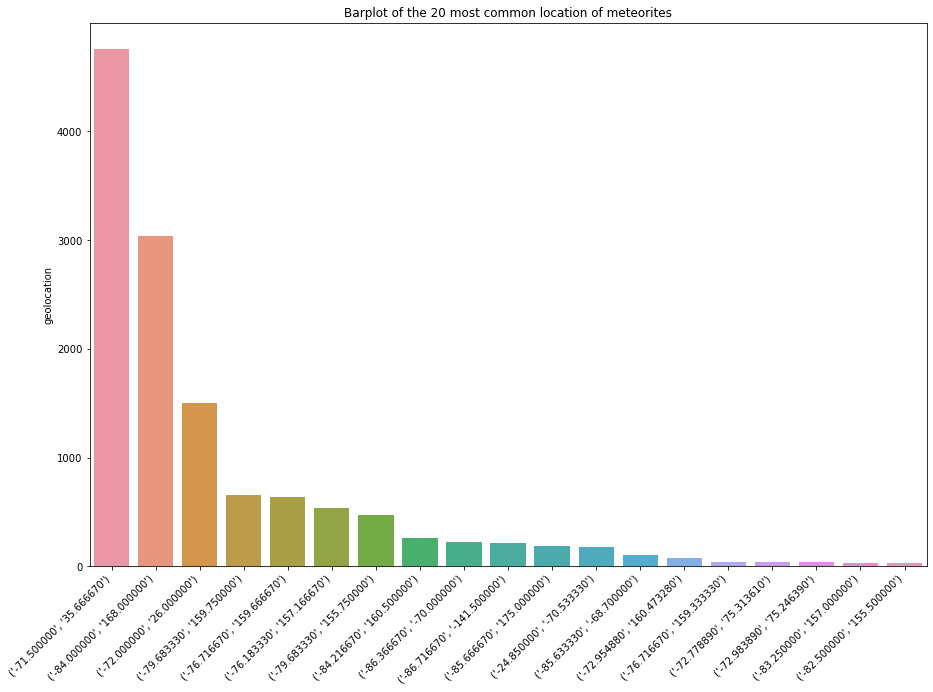

In [15]:
twenty_most_common_locations = ds_geo.value_counts()[:19]
twenty_most_common_locations = twenty_most_common_locations.sort_values(ascending=False)

common_location_barplot = sns.barplot(twenty_most_common_locations.keys(), twenty_most_common_locations);
common_location_barplot.set_xticklabels(common_location_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
common_location_barplot.set_title("Barplot of the 20 most common location of meteorites")
common_location_barplot;

The most common value: (-71.5, 35.66667) is in Antarctica. 

Let's look on the other positions of the most common geolocation on a world map:

In [21]:
m2 = folium.Map(
    zoom_start=2,
    no_touch=True)

for key in twenty_most_common_locations.keys():
    try:
        pos = eval(key)
        folium.Marker(pos).add_to(m2)
    except:
        print("Invalid position")

m2

As we can easily see now, the majority of meteorite landigs happen to be in Antarctica

### Recclass

This column describes the class of the meteorite.

There are a lot of different classes of meteorites, how ever we can devide them to 3 main categories as shown in this wiki page: https://en.wikipedia.org/wiki/Meteorite_classification

<ul>
  <li>Stony meteorites</li>
  <li>Stony-iron meteorites</li>
  <li>Iron meteorites</li>
</ul>

In [22]:
ds_recclass = df['recclass']

In [23]:
print("There are {} unique classes out of {} total".format(len(ds_recclass.unique()), len(ds_recclass)))

There are 422 unique classes out of 38115 total


We created a list with all of the subclasses of each main group according to the wiki page.

In [24]:
main_meteorite_classes = {
    "stony": ["CI", "CM", "CO", "CV", "CK", "CR", "CH", "CB", "H", "L", "LL", "E", "OC", "LLL", "HL", "EH", "EL", "R", "K", "ACAPULCOITE", "LODRANITE", "WINONAITE", "HOWARDITE", "EUCRITE", "DIOGENITE", "ANGRITE", "AUBRITE", "UREILITE", "BRACHINITE", "LUNAR", "SHERGOTTITE", "NAKHLITE", "CHASSIGNITE", "MARTIAN", "ACHONDRITE", "CHONDRITE", "RELICTOC"],
    "stony_iron": ["PALLASITE", "MESOSIDERITE"],
    "iron": ["IRON", "IC", "IIAB", "IIC", "IID", "IIF", "IIG", "IIIAB", "IIIE", "IIIF", "IVA", "IVB", "IAB", "UDEI", "PITTS", "sLL", "sLM", "sLH", "sHL", "sHH", "IIE"]
}

In [25]:
def get_category(recclass):
    # Remove numbers
    corrected_recclass = "".join(char for char in recclass if char.isalpha())

    for key in main_meteorite_classes.keys():

        if (corrected_recclass.upper() in main_meteorite_classes[key]):
            return key

        for name in main_meteorite_classes[key]:
            if (len(name) >= 3 and name in corrected_recclass.upper()):
                return key
            
    return "unclassified"

In [26]:
ds_recclass_as_df = ds_recclass.to_frame()
ds_recclass_as_df["main_category"] = ds_recclass_as_df["recclass"].apply(get_category)
ds_main_category = ds_recclass_as_df["main_category"]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


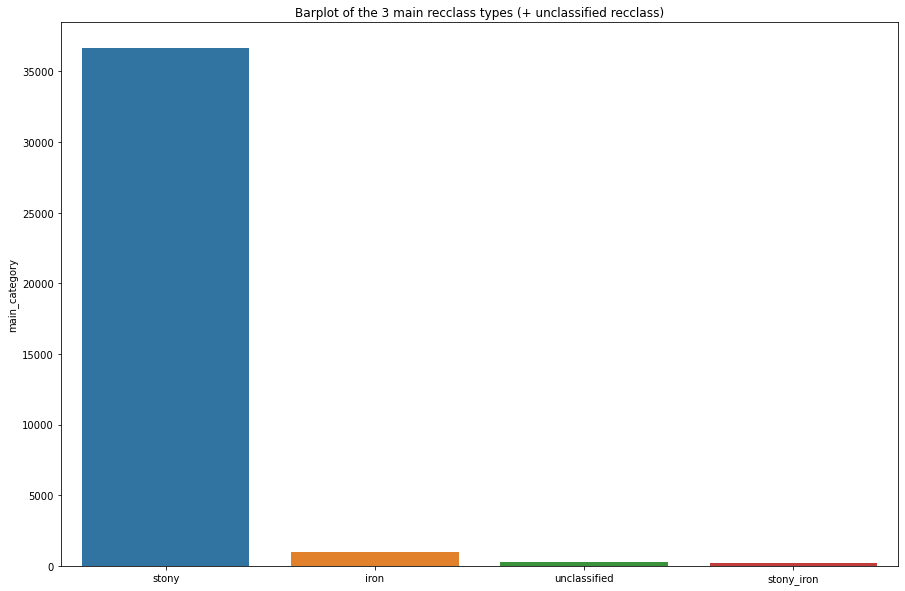

In [27]:
counted_categories = ds_main_category.value_counts()
main_category_barplot = sns.barplot(counted_categories.keys(), counted_categories)
main_category_barplot.set_xticklabels(main_category_barplot.get_xticklabels())
main_category_barplot.set_title("Barplot of the 3 main recclass types (+ unclassified recclass)")
main_category_barplot;

As we can see here, most of our stones are of the "Stony" kind

### Mass

This column relates to the mass of the given meteorite. This mass is in grams.

In [31]:
ds_mass = df['mass']

In [32]:
ds_mass.describe()

count    3.811500e+04
mean     1.560071e+04
std      6.286817e+05
min      0.000000e+00
25%      6.630000e+00
50%      2.909000e+01
75%      1.872900e+02
max      6.000000e+07
Name: mass, dtype: float64

<ul>
  <li>Lowest value is at 0 grams, max value at 60,000,000 grams (which is 60 tons)</li>
  <li>Mean is at 15,600 grams but the Median is at only 29.09 grams</li>
</ul>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of the mass')

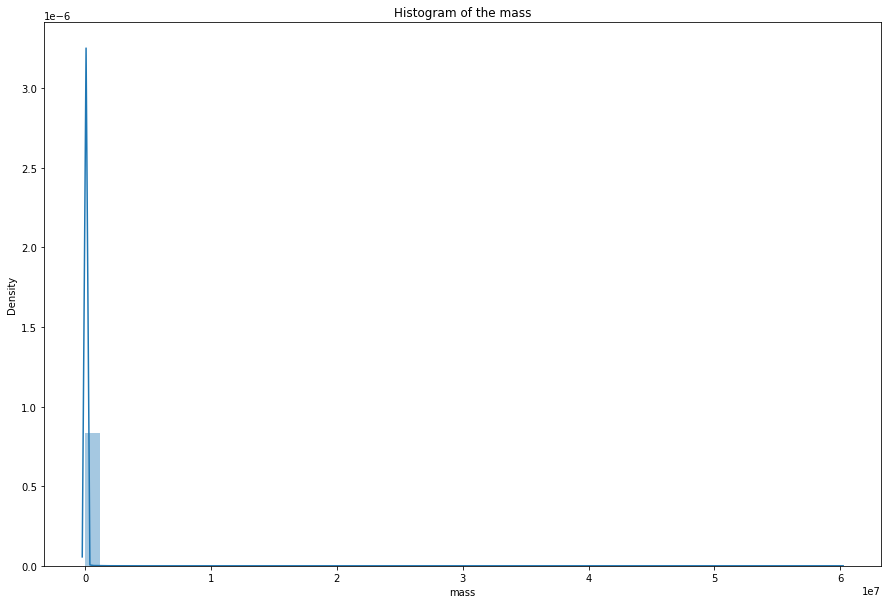

In [33]:
sns.distplot(ds_mass).set_title("Histogram of the mass")


As we can see our dataset mainly consists very lightly weighted meteorites.

### Fall

This column specifies wether or not a meteorite has been seen falling. It has two values:
<ul>
  <li>Fell: the meteorite's fall was observed</li>
    <li>Found: the meteorite's fall was <b>not</b> observed</li>
</ul>

In [34]:
ds_fall = df["fall"]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


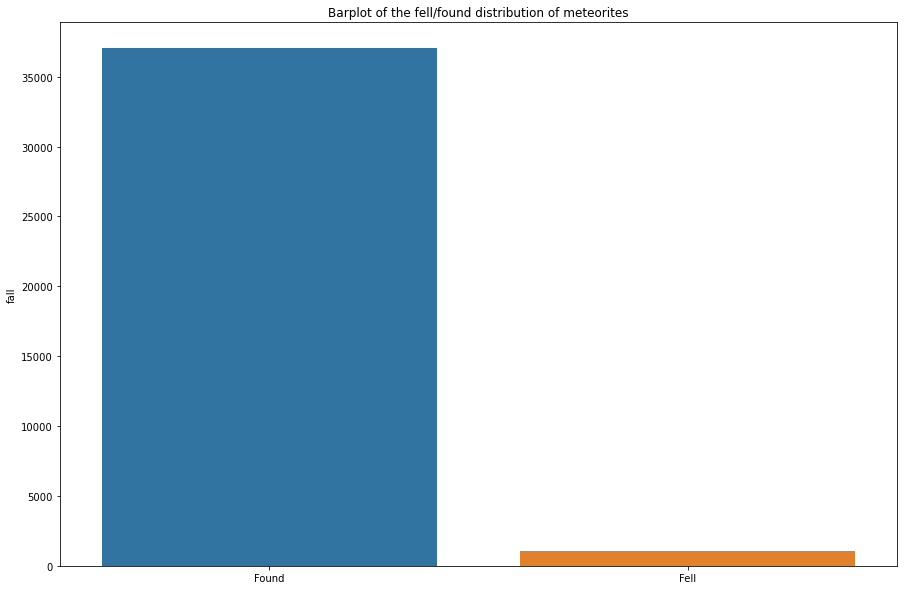

In [35]:
fell_found_count = ds_fall.value_counts()
fell_found_barplot = sns.barplot(fell_found_count.keys(), fell_found_count)

fell_found_barplot.set_title("Barplot of the fell/found distribution of meteorites")
fell_found_barplot;

As we could have expected, a lot more meteorites have only been found but not seen falling.

## Feature Correlations

### Are Meteorites more likely to be found in specific areas in the world?

In [25]:
path = "geo-data/countries.shp"

world_map = gpd.read_file(path)
world_map.head()

,OBJECTID,NAME,ISO3,ISO2,FIPS,COUNTRY,ENGLISH,FRENCH,SPANISH,LOCAL,FAO,WAS_ISO,SOVEREIGN,CONTINENT,UNREG1,UNREG2,EU,SQKM,geometry
0,1,Åland,ALA,AX,AX,Åland,Åland,None,None,Åland,None,None,Finland,Europe,Northern Europe,Europe,0,1.243719e+03,"MULTIPOLYGON (((20.99567 60.64228, 20.99261 60..."
1,2,Afghanistan,AFG,AF,AF,Afghanistan,Afghanistan,Afghanistan,Afganistán,Afghanestan,Afghanistan,None,Afghanistan,Asia,Southern Asia,Asia,0,6.413834e+05,"POLYGON ((73.27336 36.88856, 73.26195 36.89025..."
2,3,Albania,ALB,AL,AL,Albania,Albania,Albanie,Albania,Shqiperia,Albania,None,Albania,Europe,Southern Europe,Europe,0,2.848611e+04,"MULTIPOLYGON (((20.98057 40.85522, 20.98096 40..."
3,4,Algeria,DZA,DZ,AG,Algeria,Algeria,Algérie,Argelia,Al Jaza'ir,Algeria,None,Algeria,Africa,Northern Africa,Africa,0,2.316559e+06,"MULTIPOLYGON (((-8.67387 27.29807, -8.67172 27..."
4,5,American Samoa,ASM,AS,AQ,American Samoa,American Samoa,Samoa Américaines,Samoa Americana,American Samoa,American Samoa,None,United States,Oceania,Polynesia,Oceania,0,2.110151e+02,"MULTIPOLYGON (((-171.07492 -11.06860, -171.078..."


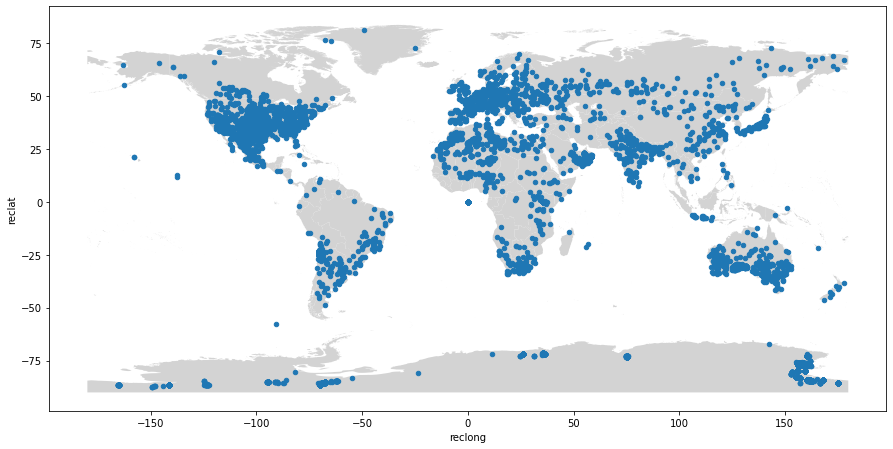

In [44]:
# initialize an axis
fig, ax = plt.subplots()
# plot map on axis
world_map.plot(color="lightgrey",ax=ax)
# plot points
df.plot(x='reclong',y='reclat', kind="scatter", colormap="YlOrRd", ax=ax)
# add grid
#ax.grid(b=True, alpha=0.5)
plt.show()

### Is there any geographical distribution difference between the observed falls and the found meteorite ?

In [26]:
from countries import *

In [27]:
c = CountryChecker(country_file='geo-data/TM_WORLD_BORDERS-0.3.shp')

In [28]:
def retrieve_country_code(lat, lon):
    #Some coordinates are set to 0 due to misisng data, we will then insert None instead
    if (lat != 0 and lon != 0):
        location = c.getCountry(Point(lat, lon))
        if location == None:
            return None
        else:
            return location.iso
    else:
        return None

In [29]:
iso_col = []

for row in tqdm(df.itertuples(index = True)):
    iso_col.append(retrieve_country_code(getattr(row,'reclat'), getattr(row,'reclong')))

df['ISO2'] = pd.Series(iso_col)

38115it [18:13, 34.85it/s] 


In [30]:
def count_iso_fell(iso_to_count):
    return len(df[(df["ISO2"] == iso_to_count) & (df["fall"] == "Fell")])

def count_iso_found(iso_to_count):
    return len(df[(df["ISO2"] == iso_to_count) & (df["fall"] == "Found")])

In [31]:
world_map['fell'] = world_map['ISO2'].apply(count_iso_fell)
world_map['found'] = world_map['ISO2'].apply(count_iso_found)

### Fell meteorites

Let's first analyze more in details which country has seen the most meteorites falling

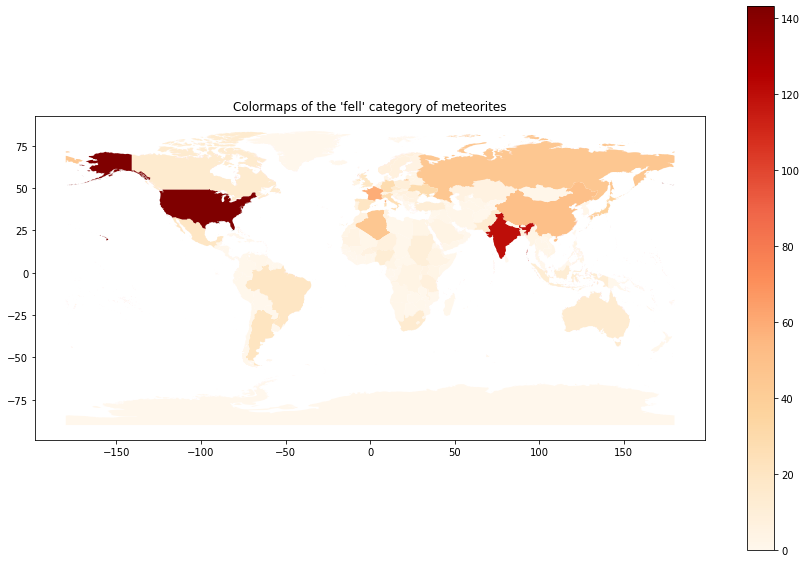

In [32]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Colormaps of the 'fell' category of meteorites")
world_map.plot(column='fell', ax=ax, legend=True, cmap='OrRd');

As we can see, meteorides have been observed falling mainly in highly popullated countries.

### Found meteorites 

Let's now see the main countries of the found meteorite.

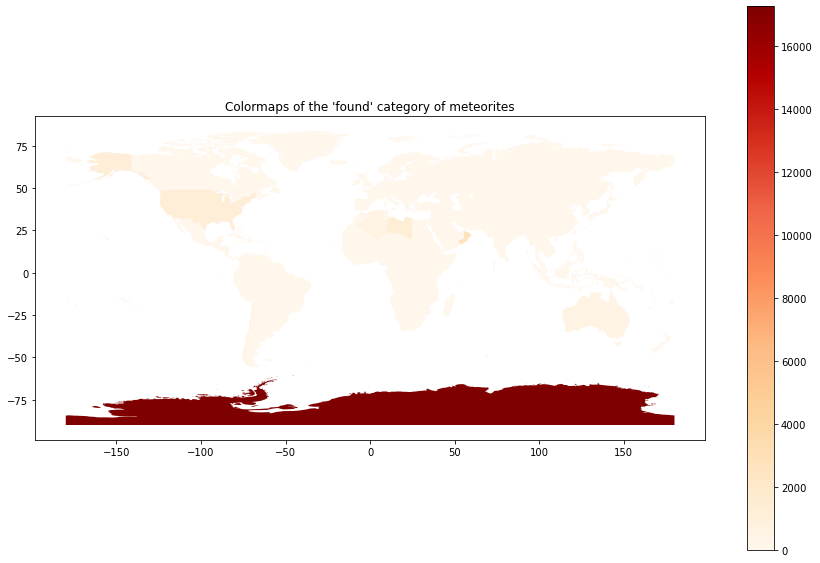

In [33]:
fig_b, ax_b = plt.subplots(1, 1)
ax_b.set_title("Colormaps of the 'found' category of meteorites")
world_map.plot(column='found', ax=ax_b, legend=True, cmap="OrRd");

As we can see most of the found meteorides are in Antarctica